Потренируемся самостоятельно писать многослойный перцептрон для работы с текстами.

Возьмем для этого датасет про юридические тексты. В этом датасете есть описания дел, а в качестве цп - то, что с делами произошло.

In [1]:
!wget https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/06-Embeddings/legal_text_classification.csv

--2025-01-10 15:41:38--  https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/06-Embeddings/legal_text_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68202412 (65M) [text/plain]
Saving to: ‘legal_text_classification.csv’

legal_text_classifi 100%[===================>]  65.04M   116MB/s    in 0.6s    

2025-01-10 15:41:39 (116 MB/s) - ‘legal_text_classification.csv’ saved [68202412/68202412]



### Бейзлайн

Для начала напишем бейзлайн - логистическую регрессию. Возьмем в качестве признаков только текст - описание самого дела (case_text). Целевую переменную, очевидно, нужно превратить в чиселки (OHE).

- проверьте данные на пропуски
- проверьте баланс классов - это очень важно!
- используйте TF-IDF
- не забудьте использовать LabelEncoder
- логистической регрессии может понадобиться выставить solver='liblinear'
- если не помните, как работать с несбалансированными датасетами, просмотрите наши конспекты - точно где-то было (на худой конец документация к логрегу)

In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('legal_text_classification.csv')
data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


In [ ]:
missing_values = data.isnull().sum().sort_values(ascending = False)
print(missing_values)

case_text       176
case_id           0
case_outcome      0
case_title        0
dtype: int64


In [4]:
data.dropna(inplace=True)

In [5]:
data.case_outcome.value_counts() # классы не очень сбалансированы

,count
case_outcome,
cited,12110
referred to,4363
applied,2438
followed,2252
considered,1699
discussed,1018
distinguished,603
related,112
approved,108


In [6]:
data.drop(['case_title', 'case_id'], axis=1, inplace=True)
data.head()

,case_outcome,case_text
0,cited,Ordinarily that discretion will be exercised s...
1,cited,The general principles governing the exercise ...
2,cited,Ordinarily that discretion will be exercised s...
3,cited,The general principles governing the exercise ...
4,cited,The preceding general principles inform the ex...


In [ ]:
data.case_outcome.unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [7]:
le = LabelEncoder()

data.case_outcome = le.fit_transform(data.case_outcome)

In [8]:
data.head(15)

,case_outcome,case_text
0,3,Ordinarily that discretion will be exercised s...
1,3,The general principles governing the exercise ...
2,3,Ordinarily that discretion will be exercised s...
3,3,The general principles governing the exercise ...
4,3,The preceding general principles inform the ex...
5,3,I accept that the making of a rolled up offer ...
6,3,The preceding general principles inform the ex...
7,3,On the question of the level of unreasonablene...
8,1,recent decision of the High Court in Australia...
9,7,Hexal Australia Pty Ltd v Roche Therapeutics I...


In [ ]:
print(data['case_outcome'].unique())

[3 1 7 8 9 4 5 6 0 2]


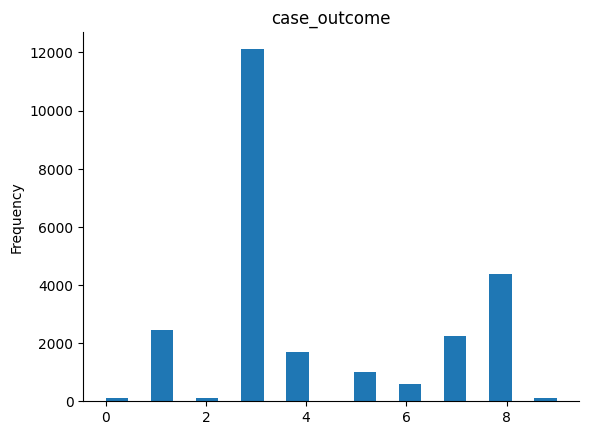

In [ ]:
# @title case_outcome

from matplotlib import pyplot as plt
data['case_outcome'].plot(kind='hist', bins=20, title='case_outcome')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
X = data.case_text
y = data.case_outcome

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [9]:
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize

In [10]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
noise = stopwords.words('english') + list(punctuation)

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.12      0.60      0.19         5
           1       0.07      0.35      0.12       125
           2       0.00      0.00      0.00         0
           3       0.96      0.54      0.69      5366
           4       0.03      0.43      0.06        30
           5       0.03      0.50      0.05        14
           6       0.00      0.00      0.00         0
           7       0.09      0.56      0.16        94
           8       0.30      0.57      0.39       569
           9       0.00      0.00      0.00         0

    accuracy                           0.54      6203
   macro avg       0.16      0.36      0.17      6203
weighted avg       0.86      0.54      0.64      6203



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Если все сделали как я, должна получиться средняя f-score в районе 0.5.

Теперь давайте попробуем написать нейронную сетку по аналогии с тетрадкой про твиттер из прошлого семинара.

### Нейронка

In [12]:
import numpy as np
from string import punctuation
from collections import Counter
from sklearn.utils import shuffle, class_weight
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

class_weight - очень полезная для нас штука. Можно вычислить веса классов автоматически с ее помощью:

In [13]:
# первый аргумент - какие веса высчитывать, второй - какие у нас классы, третий - какие их частоты
yweights = class_weight.compute_class_weight('balanced', classes=np.unique(data.case_outcome), y=data.case_outcome)

Заметьте, что возвращает оно np.array.

In [14]:
yweights = torch.tensor(yweights, dtype=torch.float32)

Нужно написать:

- функцию для предобработки текста, которая получает сырой текст и возвращает список токенов
- создать словарь word2id
- и обратный ему id2word

In [15]:
data = shuffle(data[['case_outcome', 'case_text']], random_state=42)

In [16]:
data.head()

,case_outcome,case_text
8093,1,agreed elements of the action for breach of co...
2459,3,The Episodes must be considered in their entir...
3260,3,The respondents argued that the concept of pro...
2874,6,Part 7 was inserted into the Native Title Act ...
18498,1,to the applicant's primary submission that pri...


In [17]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens if token not in noise] # добавила в обработку текста удаление «шума» (стоп-слов)
    return tokens

In [18]:
vocab = Counter()

for text in data['case_text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 63361


In [19]:
# отсеиваем редкие слова
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('Уникальные токены, которых встретились больше 2 раз:', len(filtered_vocab))

Уникальные токены, которых встретились больше 2 раз: 38227


In [20]:
MAX_LEN = 0

for text in data.case_text:
    tokens = preprocess(text)
    MAX_LEN = max(len(tokens), MAX_LEN)
MAX_LEN

12540

In [21]:
word2id = {'PAD': 0}

for word in filtered_vocab:
  word2id[word] = len(word2id)

In [22]:
id2word = {i: word for word, i in word2id.items()}

Лучше это все, конечно, запускать в колабе... не забудьте там выбрать T4 GPU в рантайме

In [23]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [24]:
train_sentences, val_sentences = train_test_split(data, test_size=0.1, random_state=42)

In [25]:
X = torch.LongTensor(size=(train_sentences.shape[0], MAX_LEN))

for i, text in enumerate(train_sentences.case_text):
    tokens = preprocess(text) # токенизируем

    ids = [word2id[token] for token in tokens if token in word2id][:MAX_LEN]

    ids = F.pad(torch.LongTensor(ids), (0, MAX_LEN - len(ids)))
    X[i] = ids

In [ ]:
print(X[4].shape)
print(X[4])
print([id2word[int(id_)] for id_ in  X[4]])

torch.Size([12540])
tensor([ 3951, 27908, 29707,  ...,     0,     0,     0])
["tribunal's", 'decision', 'accept', "appellant's", 'documents', 'reliable', 'corroboration', 'claims', 'based', 'part', 'inconsistency', 'documents', 'oral', 'evidence', 'evidence', 'tribunal', 'alerted', 'appellant', 'issue', 'although', 'relied', 'upon', 'appellant', 'raised', 'point', 'counsel', 'respondent', 'accept', 'submission', "tribunal's", 'reasoning', 'cannot', 'characterised', 'constituting', 'information', 'within', 'meaning', '424a(1)(a', 'szbyr', 'v', 'minister', 'immigration', 'citizenship', '2007', '235', 'alr', '609', '18', 'obliged', 'notify', 'appellant', 'advance', 'doubts', 'arising', 'inconsistencies', '12', 'appeal', 'dismissed', 'appellant', 'pay', 'costs', 'first', 'respondent', 'certify', 'preceding', 'twelve', '12', 'numbered', 'paragraphs', 'true', 'copy', 'reasons', 'judgment', 'herein', 'honourable', 'justice', 'gyles', 'associate', 'dated', '7', 'december', '2007', 'appellant',

In [26]:
X = pad_sequence(X, batch_first=True)
X.shape

torch.Size([22328, 12540])

Нужно написать класс для нашего датасета (можно беспощадно копипастить из тетрадки про твиттер)

In [27]:
class LegalDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['case_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['case_outcome'].values
        self.device = DEVICE

    def __len__(self): # считаем длину датасета
        return self.length

    def __getitem__(self, index): # По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизация
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = self.target[index]
        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens if token not in noise] # убираю стоп-слова из нойза (правда модель стала обучаться в 2 раза дольше...)
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): # сопоставляет х и у
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True, padding_value=0).to(self.device)

      y = torch.tensor(y, dtype=torch.long).to(self.device) # type long для многоклассовой классификации

      return padded_ids, y

In [28]:
train_dataset = LegalDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(
    train_dataset,
    collate_fn=train_dataset.collate_fn,
    sampler=train_sampler,
    batch_size=256)

In [29]:
val_dataset = LegalDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(
    val_dataset,
    collate_fn=val_dataset.collate_fn,
    sampler=val_sampler,
    batch_size=256)

Ну и наконец напишем архитектуру. Модель при инициализации должна принимать размер словаря и эмбеддинга. У нас в датасете 10 классов, поэтому, в отличие от тетрадки про твиттер, нужно использовать Softmax и возвращать вероятности классов. В качестве лосса подойдет кросс-энтропия (я ее уже за вас вписала вместе с весами классов).

In [30]:
# взяла из тетрадки
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb2h = nn.Linear(embedding_dim, 64)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.h2out = nn.Linear(64, 10) # 10 классов на выходе
        # self.act2 = nn.Softmax(dim=1)


    def forward(self, text):
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов

        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения

        hidden = self.emb2h(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden) # [batch_size, 10]
        # proba = self.act2(out)

        return out

In [31]:
batch, y = next(iter(train_iterator))

In [32]:
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch.shape)
print(y.shape)

torch.Size([256, 11007])
torch.Size([256])


In [ ]:
print(y)

tensor([3, 7, 8, 3, 5, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 8, 1, 3, 1, 3, 4, 1, 8, 5,
        3, 8, 5, 3, 3, 1, 3, 3, 8, 3, 8, 3, 3, 8, 3, 7, 1, 6, 3, 8, 3, 3, 3, 8,
        8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3,
        3, 8, 8, 3, 3, 3, 3, 7, 3, 3, 1, 3, 3, 4, 1, 3, 3, 6, 3, 3, 6, 3, 6, 1,
        3, 3, 5, 7, 3, 3, 3, 8, 9, 3, 3, 3, 8, 3, 3, 4, 4, 3, 4, 7, 7, 7, 3, 3,
        8, 3, 3, 5, 6, 8, 7, 7, 8, 1, 3, 8, 4, 3, 1, 3, 1, 3, 7, 7, 3, 7, 2, 5,
        3, 3, 3, 3, 8, 7, 3, 3, 8, 5, 6, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3,
        3, 8, 8, 3, 8, 1, 4, 8, 3, 3, 8, 3, 3, 8, 8, 4, 8, 7, 4, 6, 8, 8, 3, 7,
        1, 3, 7, 1, 1, 4, 3, 3, 5, 8, 3, 1, 8, 1, 3, 3, 7, 3, 7, 3, 8, 3, 3, 3,
        1, 4, 7, 7, 1, 7, 4, 3, 3, 4, 8, 6, 8, 5, 3, 4, 8, 3, 8, 3, 3, 8, 1, 8,
        8, 1, 3, 3, 3, 3, 8, 5, 3, 1, 8, 8, 3, 5, 3, 3])


In [ ]:
#пропустим через модель наш первый батч, чтобы проверить, что все работает
model = MLP(len(id2word), 5)
output = torch.argmax(model(batch), dim=1) # argmax из вероятностей сделает классы
output

tensor([9, 9, 9, 9, 9, 9, 8, 9, 9, 2, 9, 9, 9, 9, 8, 9, 9, 9, 9, 2, 9, 9, 2, 9,
        9, 9, 2, 9, 9, 9, 8, 8, 9, 2, 2, 9, 9, 8, 9, 9, 2, 8, 9, 9, 9, 9, 2, 9,
        2, 9, 9, 9, 9, 8, 9, 9, 2, 2, 8, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 8, 2, 9,
        9, 2, 8, 9, 9, 2, 9, 9, 9, 7, 9, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 2, 9, 7,
        9, 2, 9, 2, 9, 8, 8, 2, 9, 9, 9, 7, 8, 2, 9, 9, 8, 9, 8, 9, 9, 2, 8, 9,
        9, 9, 9, 9, 9, 9, 2, 9, 2, 9, 2, 8, 2, 9, 9, 9, 9, 2, 2, 2, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 8, 2, 7, 9, 8, 9, 8, 9, 8, 7, 8, 8, 7, 9, 9, 2, 2, 9,
        2, 9, 9, 8, 9, 2, 9, 9, 9, 9, 9, 8, 9, 9, 8, 9, 8, 9, 2, 8, 9, 9, 8, 9,
        2, 2, 8, 2, 9, 2, 2, 9, 9, 9, 9, 2, 9, 8, 2, 9, 8, 9, 9, 8, 9, 2, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 9, 9, 9, 9, 8, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 8, 2, 9, 9, 9, 9, 2, 8])

Теперь нужно написать трейнлуп (лучше скопипастить откуда-нибудь), инициализировать нашу модель и запустить)

In [33]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator): # итерируемся по батчам
        optimizer.zero_grad()
        preds_proba = model(texts) # прогоняем данные через модель

        loss = criterion(preds_proba, ys)
        loss.backward() # считаем градиенты

        optimizer.step() # обновляем веса

        epoch_loss += loss.item() # сохраняем значение функции потерь

    return epoch_loss / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0

    model.eval()

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            texts = texts.to(DEVICE)
            ys = ys.to(DEVICE)
            predictions = model(texts)

            loss = criterion(predictions, ys)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [35]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

#### Try №1

NB: когда я первый раз обучала модель, размер батча был 1024, потом я уменьшила до 256

In [ ]:
model = MLP(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
yweights = yweights.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=yweights)

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'\nstarting Epoch {epoch + 1}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)

    if (epoch + 1) % 10 == 0 or epoch == 0:
      print(f'Epoch {epoch + 1}/{EPOCHS}:\n\tTrain loss: {epoch_loss:.6f}\n\tVal loss: {epoch_loss_on_test:.6f}')


starting Epoch 1
Training...

Validating...
Epoch 1/100:
	Train loss: 2.324796
	Val loss: 2.299164

starting Epoch 2
Training...

Validating...

starting Epoch 3
Training...

Validating...

starting Epoch 4
Training...

Validating...

starting Epoch 5
Training...

Validating...

starting Epoch 6
Training...

Validating...

starting Epoch 7
Training...

Validating...

starting Epoch 8
Training...

Validating...

starting Epoch 9
Training...

Validating...

starting Epoch 10
Training...

Validating...
Epoch 10/100:
	Train loss: 2.301440
	Val loss: 2.305406

starting Epoch 11
Training...

Validating...

starting Epoch 12
Training...

Validating...

starting Epoch 13
Training...

Validating...

starting Epoch 14
Training...

Validating...

starting Epoch 15
Training...

Validating...

starting Epoch 16
Training...

Validating...

starting Epoch 17
Training...

Validating...

starting Epoch 18
Training...

Validating...

starting Epoch 19
Training...

Validating...

starting Epoch 20
Train

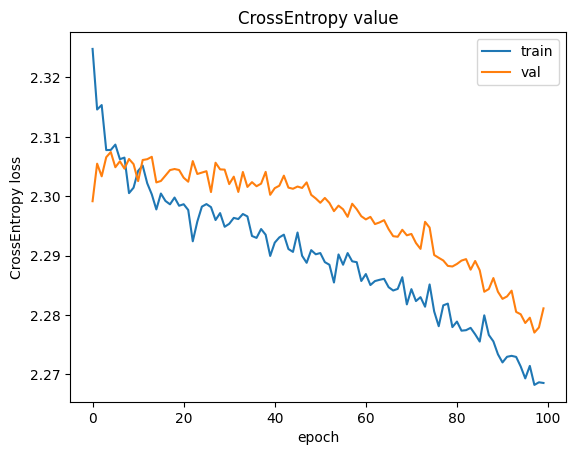

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Судя по всему, получается переобучение + лосс снижается довольно медленно.

#### Try №2

##### 2.1

Попробую увеличить количество нейронов и добавить еще один скрытый слой + увеличить размер эмбеддингов:

In [ ]:
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.emb2h = nn.Linear(embedding_dim, 128)
        self.act1 = nn.ReLU()

        self.h2h2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

        self.h2out = nn.Linear(64, 10) # 10 классов на выходе


    def forward(self, text):
        embedded = self.embedding(text)
        mean_emb = torch.mean(embedded, dim=1)

        hidden = self.emb2h(mean_emb)
        hidden = self.act1(hidden)
        hidden = self.h2h2(hidden)
        hidden = self.act2(hidden)
        hidden = self.dropout(hidden)

        out = self.h2out(hidden) # [batch_size, 10]

        return out

In [ ]:
model2 = MLP(len(word2id), 100) # 5 --> 100
optimizer = optim.Adam(model2.parameters(), lr=0.001)
yweights = yweights.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=yweights)

model2 = model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses2 = []
losses_eval2 = []
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'\nstarting Epoch {epoch + 1}')
    epoch_loss = train(model2, train_iterator, optimizer, criterion)
    losses2.append(epoch_loss)

    epoch_loss_on_test = evaluate(model2, val_iterator, criterion)
    losses_eval2.append(epoch_loss_on_test)

    if (epoch + 1) % 10 == 0 or epoch == 0:
      print(f'Epoch {epoch + 1}/{EPOCHS}:\n\tTrain loss: {epoch_loss:.6f}\n\tVal loss: {epoch_loss_on_test:.6f}')


starting Epoch 1
Training...

Validating...
Epoch 1/100:
	Train loss: 2.308726
	Val loss: 2.302097

starting Epoch 2
Training...

Validating...

starting Epoch 3
Training...

Validating...

starting Epoch 4
Training...

Validating...

starting Epoch 5
Training...

Validating...

starting Epoch 6
Training...

Validating...

starting Epoch 7
Training...

Validating...

starting Epoch 8
Training...

Validating...

starting Epoch 9
Training...

Validating...

starting Epoch 10
Training...

Validating...
Epoch 10/100:
	Train loss: 2.296357
	Val loss: 2.303342

starting Epoch 11
Training...

Validating...

starting Epoch 12
Training...

Validating...

starting Epoch 13
Training...

Validating...

starting Epoch 14
Training...

Validating...

starting Epoch 15
Training...

Validating...

starting Epoch 16
Training...

Validating...

starting Epoch 17
Training...

Validating...

starting Epoch 18
Training...

Validating...

starting Epoch 19
Training...

Validating...

starting Epoch 20
Train

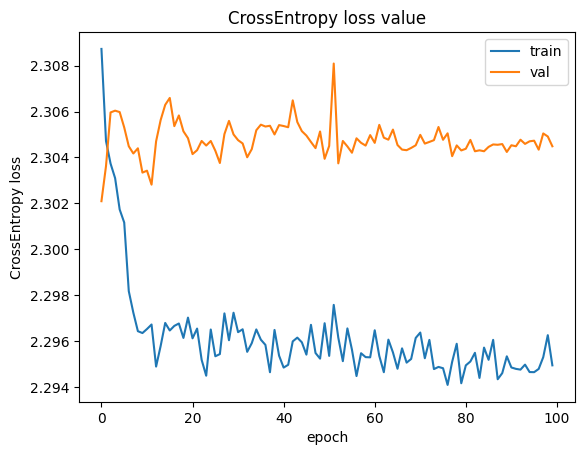

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses2)
plt.plot(losses_eval2)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Не особо похоже на обучение...(

##### 2.2 (лучший результат)

Оставлю архитектуру с одним слоем и просто увеличу размерность эмбеддингов:

In [ ]:
# взяла из тетрадки
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb2h = nn.Linear(embedding_dim, 64)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.h2out = nn.Linear(64, 10) # 10 классов на выходе
        # self.act2 = nn.Softmax(dim=1)


    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.mean(embedded, dim=1)

        hidden = self.emb2h(mean_emb)
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden) # [batch_size, 10]
        # proba = self.act2(out)

        return out

In [ ]:
model1 = MLP(len(word2id), 100) # 5 --> 100
optimizer = optim.Adam(model1.parameters(), lr=0.001)
yweights = yweights.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=yweights)

model1 = model1.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses1 = []
losses_eval1 = []
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'\nstarting Epoch {epoch + 1}')
    epoch_loss = train(model1, train_iterator, optimizer, criterion)
    losses1.append(epoch_loss)

    epoch_loss_on_test = evaluate(model1, val_iterator, criterion)
    losses_eval1.append(epoch_loss_on_test)

    if (epoch + 1) % 10 == 0 or epoch == 0:
      print(f'Epoch {epoch + 1}/{EPOCHS}:\n\tTrain loss: {epoch_loss:.6f}\n\tVal loss: {epoch_loss_on_test:.6f}')


starting Epoch 1
Training...

Validating...
Epoch 1/100:
	Train loss: 2.314622
	Val loss: 2.311296

starting Epoch 2
Training...

Validating...

starting Epoch 3
Training...

Validating...

starting Epoch 4
Training...

Validating...

starting Epoch 5
Training...

Validating...

starting Epoch 6
Training...

Validating...

starting Epoch 7
Training...

Validating...

starting Epoch 8
Training...

Validating...

starting Epoch 9
Training...

Validating...

starting Epoch 10
Training...

Validating...
Epoch 10/100:
	Train loss: 2.295394
	Val loss: 2.300845

starting Epoch 11
Training...

Validating...

starting Epoch 12
Training...

Validating...

starting Epoch 13
Training...

Validating...

starting Epoch 14
Training...

Validating...

starting Epoch 15
Training...

Validating...

starting Epoch 16
Training...

Validating...

starting Epoch 17
Training...

Validating...

starting Epoch 18
Training...

Validating...

starting Epoch 19
Training...

Validating...

starting Epoch 20
Train

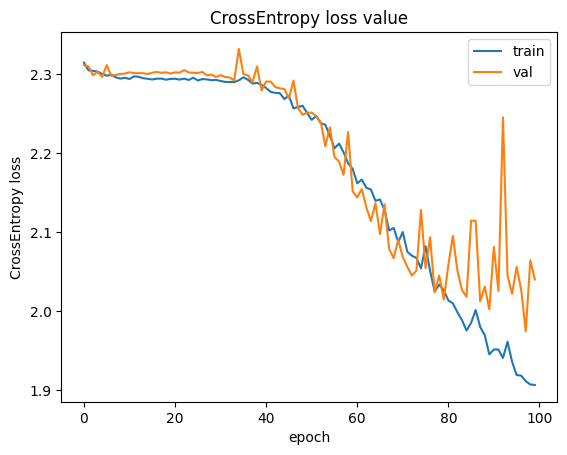

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses1)
plt.plot(losses_eval1)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
min(losses1), min(losses_eval1)

(1.9064902934161099, 1.9742363810539245)

Интересно... После 80-й эпохи лосс начал неистово скакать, возможно, можно задать поменьше эпох. Переобучение все равно сохраняется.

Вообще, когда я впервые за 4 дня увидела лосс меньше 2.3, я уже ликовала :)

##### 2.3

Попробую увеличить дропаут до 0.5 и уменьшить размерность эмбеддингов до 50:

In [ ]:
# взяла из тетрадки
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb2h = nn.Linear(embedding_dim, 64)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) # 0.3 --> 0.5
        self.h2out = nn.Linear(64, 10) # 10 классов на выходе
        # self.act2 = nn.Softmax(dim=1)


    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.mean(embedded, dim=1)

        hidden = self.emb2h(mean_emb)
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden) # [batch_size, 10]
        # proba = self.act2(out)

        return out

In [ ]:
model1_1 = MLP(len(word2id), 50) # 100 --> 50
optimizer = optim.Adam(model1_1.parameters(), lr=0.001)
yweights = yweights.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=yweights)

model1_1 = model1_1.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses1_1 = []
losses_eval1_1 = []
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'\nstarting Epoch {epoch + 1}')
    epoch_loss = train(model1_1, train_iterator, optimizer, criterion)
    losses1_1.append(epoch_loss)

    epoch_loss_on_test = evaluate(model1_1, val_iterator, criterion)
    losses_eval1_1.append(epoch_loss_on_test)

    if (epoch + 1) % 10 == 0 or epoch == 0:
      print(f'Epoch {epoch + 1}/{EPOCHS}:\n\tTrain loss: {epoch_loss:.6f}\n\tVal loss: {epoch_loss_on_test:.6f}')


starting Epoch 1
Training...

Validating...
Epoch 1/100:
	Train loss: 2.315290
	Val loss: 2.303239

starting Epoch 2
Training...

Validating...

starting Epoch 3
Training...

Validating...

starting Epoch 4
Training...

Validating...

starting Epoch 5
Training...

Validating...

starting Epoch 6
Training...

Validating...

starting Epoch 7
Training...

Validating...

starting Epoch 8
Training...

Validating...

starting Epoch 9
Training...

Validating...

starting Epoch 10
Training...

Validating...
Epoch 10/100:
	Train loss: 2.294362
	Val loss: 2.305258

starting Epoch 11
Training...

Validating...

starting Epoch 12
Training...

Validating...

starting Epoch 13
Training...

Validating...

starting Epoch 14
Training...

Validating...

starting Epoch 15
Training...

Validating...

starting Epoch 16
Training...

Validating...

starting Epoch 17
Training...

Validating...

starting Epoch 18
Training...

Validating...

starting Epoch 19
Training...

Validating...

starting Epoch 20
Train

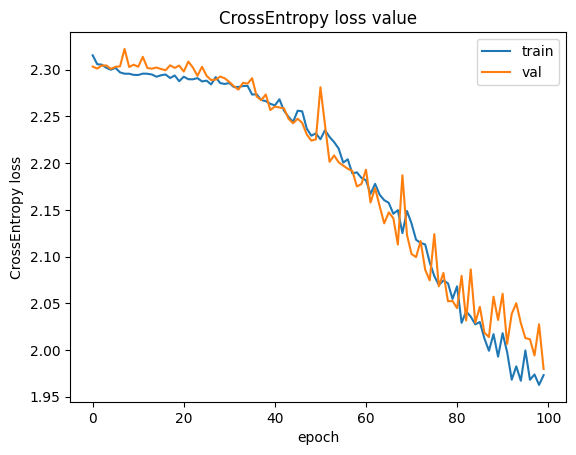

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses1_1)
plt.plot(losses_eval1_1)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
min(losses1_1), min(losses_eval1_1)

(1.962616654959592, 1.9796864867210389)

Не особо что изменилось, но график выглядит лучше

#### Try №3 (новый)

Попробую увеличить количество нейронов и добавить еще один скрытый слой + увеличить lr до 0.005:

In [ ]:
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.emb2h = nn.Linear(embedding_dim, 128)
        self.act1 = nn.ReLU()

        self.h2h2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3) # 0.5 --> 0.3

        self.h2out = nn.Linear(64, 10) # 10 классов на выходе


    def forward(self, text):
        embedded = self.embedding(text)
        mean_emb = torch.mean(embedded, dim=1)

        hidden = self.emb2h(mean_emb)
        hidden = self.act1(hidden)
        hidden = self.h2h2(hidden)
        hidden = self.act2(hidden)
        hidden = self.dropout(hidden)

        out = self.h2out(hidden) # [batch_size, 10]

        return out

In [ ]:
model2_1 = MLP(len(word2id), 100)
optimizer = optim.Adam(model2_1.parameters(), lr=0.005) # 0.001 --> 0.005
yweights = yweights.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=yweights)

model2_1 = model2_1.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses2_1 = []
losses_eval2_1 = []
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'\nstarting Epoch {epoch + 1}')
    epoch_loss = train(model2_1, train_iterator, optimizer, criterion)
    losses2_1.append(epoch_loss)

    epoch_loss_on_test = evaluate(model2_1, val_iterator, criterion)
    losses_eval2_1.append(epoch_loss_on_test)

    if (epoch + 1) % 10 == 0 or epoch == 0:
      print(f'Epoch {epoch + 1}/{EPOCHS}:\n\tTrain loss: {epoch_loss:.6f}\n\tVal loss: {epoch_loss_on_test:.6f}')


starting Epoch 1
Training...

Validating...
Epoch 1/100:
	Train loss: 2.309559
	Val loss: 2.306598

starting Epoch 2
Training...

Validating...

starting Epoch 3
Training...

Validating...

starting Epoch 4
Training...

Validating...

starting Epoch 5
Training...

Validating...

starting Epoch 6
Training...

Validating...

starting Epoch 7
Training...

Validating...

starting Epoch 8
Training...

Validating...

starting Epoch 9
Training...

Validating...

starting Epoch 10
Training...

Validating...
Epoch 10/100:
	Train loss: 2.295262
	Val loss: 2.302971

starting Epoch 11
Training...

Validating...

starting Epoch 12
Training...

Validating...

starting Epoch 13
Training...

Validating...

starting Epoch 14
Training...

Validating...

starting Epoch 15
Training...

Validating...

starting Epoch 16
Training...

Validating...

starting Epoch 17
Training...

Validating...

starting Epoch 18
Training...

Validating...

starting Epoch 19
Training...

Validating...

starting Epoch 20
Train

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-36a4d278832e>", line 7, in <cell line: 5>
    epoch_loss = train(model2_1, train_iterator, optimizer, criterion)
  File "<ipython-input-29-ca0e6d01b893>", line 7, in train
    for i, (texts, ys) in enumerate(iterator): # итерируемся по батчам
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 757, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/

TypeError: object of type 'NoneType' has no len()

Остановила раньше, потому что всё стало только хуже и лосс практически не менялся...(

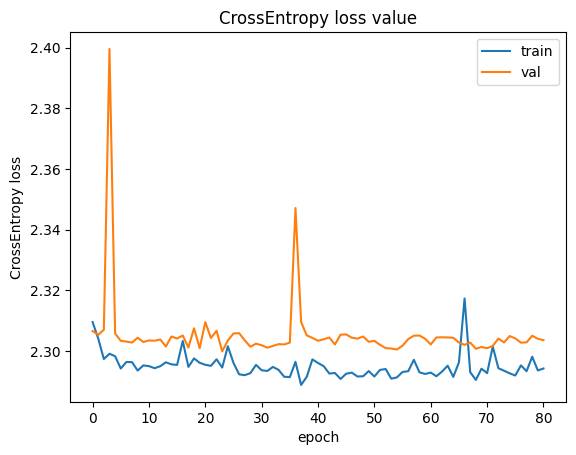

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses2_1)
plt.plot(losses_eval2_1)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Видимо, более сложная архитектура не особо помогла...

- включить обучение эмбеддингов
- оставить lr 0.001
- нормализация батчей
- scheduler

#### Try №4

Архитектуру оставлю самую первую с размером эмбеддингов 100, попробую включить обучение эмбеддингов:

In [39]:
import gensim

In [40]:
texts = data.case_text.apply(preprocess).tolist()

In [41]:
len(texts)

24809

In [42]:
w2v = gensim.models.Word2Vec(texts, window=5, min_count=1, vector_size=100)

In [43]:
# делаем матрицу весов
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = w2v.wv[word]
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0, 0.1, 100)

In [48]:
weights

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.09895897e-02, -2.55982566e+00,  1.42395842e+00, ...,
        -9.13800836e-01, -1.67631209e+00,  9.15001512e-01],
       [-1.88146144e-01,  1.50166795e-01, -1.40145540e-01, ...,
         3.62048715e-01,  1.88127667e-01,  4.47939306e-01],
       ...,
       [-7.08542585e-01,  1.46024615e-01,  3.86889949e-02, ...,
         3.41235936e-01, -2.81552881e-01,  3.23818833e-01],
       [-5.09472303e-02,  2.18573287e-02, -3.15229483e-02, ...,
        -6.17822483e-02,  7.35276146e-04, -1.20749548e-01],
       [-1.22653790e-01,  1.42897844e-01, -2.98063569e-02, ...,
         1.50728235e-02, -8.22372809e-02,  1.20292706e-02]])

In [44]:
count # всё сработало

0

In [49]:
# взяла из тетрадки
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.emb2h = nn.Linear(embedding_dim, 64)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.h2out = nn.Linear(64, 10)


    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.mean(embedded, dim=1)

        hidden = self.emb2h(mean_emb)
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden) # [batch_size, 10]

        return out

In [50]:
model3 = MLP(len(word2id), 100)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
yweights = yweights.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=yweights)

model3 = model3.to(DEVICE)
criterion = criterion.to(DEVICE)

In [51]:
losses3 = []
losses_eval3 = []
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f'\nstarting Epoch {epoch + 1}')
    epoch_loss = train(model3, train_iterator, optimizer, criterion)
    losses3.append(epoch_loss)

    epoch_loss_on_test = evaluate(model3, val_iterator, criterion)
    losses_eval3.append(epoch_loss_on_test)

    if (epoch + 1) % 10 == 0 or epoch == 0:
      print(f'Epoch {epoch + 1}/{EPOCHS}:\n\tTrain loss: {epoch_loss:.6f}\n\tVal loss: {epoch_loss_on_test:.6f}')


starting Epoch 1
Training...

Validating...
Epoch 1/100:
	Train loss: 2.319144
	Val loss: 2.312631

starting Epoch 2
Training...

Validating...

starting Epoch 3
Training...

Validating...

starting Epoch 4
Training...

Validating...

starting Epoch 5
Training...

Validating...

starting Epoch 6
Training...

Validating...

starting Epoch 7
Training...

Validating...

starting Epoch 8
Training...

Validating...

starting Epoch 9
Training...

Validating...

starting Epoch 10
Training...

Validating...
Epoch 10/100:
	Train loss: 2.295880
	Val loss: 2.303202

starting Epoch 11
Training...

Validating...

starting Epoch 12
Training...

Validating...

starting Epoch 13
Training...

Validating...

starting Epoch 14
Training...

Validating...

starting Epoch 15
Training...

Validating...

starting Epoch 16
Training...

Validating...

starting Epoch 17
Training...

Validating...

starting Epoch 18
Training...

Validating...

starting Epoch 19
Training...

Validating...

starting Epoch 20
Train

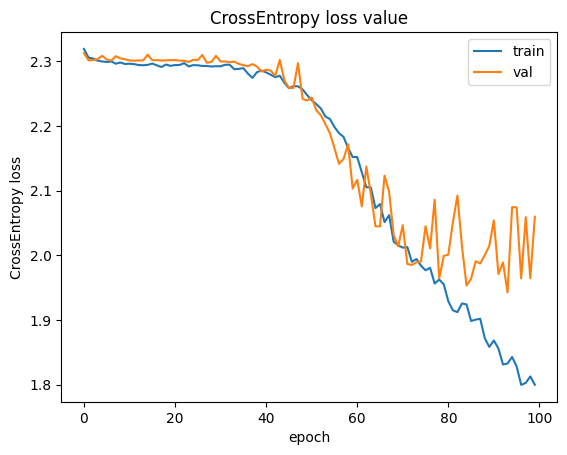

In [52]:
import matplotlib.pyplot as plt
plt.plot(losses3)
plt.plot(losses_eval3)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Кажется, в какой-то момент переобучение удалось избежать, но лосс начал опять неистово скакать, несмотря на то что на трейне модель обучается хорошо. Судя по графику, лосс на тесте тут не получился лучшим (у меня сразу же отвалилась среда выполнения Т4, поэтому переменные со значениями лоссов не сохранились...)

----------------------------

Итог: вообще пробовала я всякого намного больше, в т.ч. нормализацию батчей, добавляла еще больше слоев с еще большим количеством нейронов, больше меня lr, меняла функцию активации на LeakyReLU, это всё не особо помогало (нормализация батчей наоборот почему-то всё испортила...). Заметное улучшение произошло после того, как я увеличила размер эмбеддингов.

Можно было так же применить scheduler, взять попробовать другой оптимизатор, взять другие предобученные эбмеддинги (и, может, даже сначала заморозить их на первых нескольких слоях), аугментировать данные. Тут как будто конца и края нет экспериментам... Хотя от перцептрона может и не нужно ждать каких-то вау результатов...)